In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from Bio import Phylo

import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import minimize
import pandas as pd

In [3]:
import rooting_methods
import rooting_methods_v2

# Going through another round of speed-up / simplification (ideally)

In [507]:
# tree = Phylo.read('../../Tree_rooting/Data/raw_OMA_trees/OMAGroup_479938.mafft.afa.treefile.Rooted.MPAJH', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick')
# rooted_tree.root_with_outgroup(['ELI', 'MAL'], outgroup_branch_length=10e-6)
# tree = Phylo.read(StringIO('(((A:20, B:20):30,C:50):30, D:80)'), 'newick', rooted=False)
tree = Phylo.read('../../Tree_rooting/Data/Tria_et_al_data/eukaryotes/processed_trees/'
                  'KOG0018.faa.aln.nwk.Rooted.MPAJH', 'newick')
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')
rooted_tree = rooting_methods.mp_root_adhock(tree)
# Phylo.draw(rooted_tree)

In [504]:
new_tree_a, RAI_a, fxn_optima_a = rooting_methods.mad_root_adhock(rooted_tree)

In [508]:
new_tree_b, RAI_b, fxn_optima_b = rooting_methods_v2.mad_root_adhock(rooted_tree)

In [509]:
[i.branch_length for i in new_tree_a.root.clades],\
[i.branch_length for i in new_tree_b.root.clades]

([0.15697918855981485, 0.31046081144018517],
 [0.15697918855981491, 0.31046081144018511])

In [510]:
[len(i.get_terminals()) for i in new_tree_a.root.clades],\
[len(i.get_terminals()) for i in new_tree_b.root.clades]

([14, 17], [14, 17])

In [443]:
RAI_a, RAI_b

(0.97812063642480973, 0.97812063642481994)

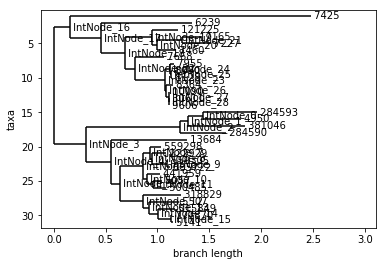

In [312]:
Phylo.draw(new_tree_b)

1267650600228229401496703205376

In [53]:
data = np.arange(25).reshape(5,5)
data

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [57]:
data[::data.shape[0]-1, ::data.shape[1]-1]


array([[ 0,  4],
       [20, 24]])

In [56]:
data[::data.shape[0]-1, ::data.shape[1]-1]

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [65]:
data[::data.shape[0]-1,:]

array([[ 0,  1,  2,  3,  4],
       [20, 21, 22, 23, 24]])

In [66]:
data[:,::data.shape[1]-1]

array([[ 0,  4],
       [ 5,  9],
       [10, 14],
       [15, 19],
       [20, 24]])

In [ ]:
data[::data.shape[0]-1,:]

In [77]:
blah = np.delete(data,np.s_[2:4],1)
blah = np.delete(blah,np.s_[2:4],0)
# np.delete(a,[0,2],1)


In [231]:
data

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [254]:
data[0:1, np.r_[:1, 2:5]]

array([[0, 2, 3, 4]])

In [253]:
data.shape

(5, 5)

# \*\*\*Everything below here is a total old mess\*\*\*

# Minimal Ancestor Deviation

**Working version 1**

On at least a few test cases.

Horrendously slow / un-scalable

In [ ]:
def optimize_root_loc_on_branch_mad_v1(tree):
    '''
    This will calculate (and optimize) the ancestor deviation on a given branch
    
        `tree` is a Bio.Phylo tree object that must be rooted (and only bifurcating roots)
                will suffice. This function will only explore moving this root location
                within the bounds of the next nodes
    
    Note: calculating the MAD for the whole tree will thus require running this function on every
    putative root branch and selecting the best branch / location on that branch as the root.
    '''
    assert len(tree.root.clades) == 2
    lterms = tree.root.clades[0].get_terminals()
    rterms = tree.root.clades[1].get_terminals()
    ####################################################
    ####################################################
    ###This is slow and inefficient where I'm essentially computing a distance
    ###matrix from the tree object. Since this function only operates on a single
    ###branch, I end up repeating this tedious calculation surely more than necessary.
    ###There might be a way to speed it up with some clever array operations and/or 
    ###recursion. Or at least passing this dictionary between putative roots 
    ###(with necessary modifications, since it *must* change *slightly* from root-to-root)
    lineage_dist_dict = {}
    for leaf in tree.get_terminals():
        lineage_dist_dict[leaf] = {}
        full_lineage = tree.trace(tree.root, leaf)
        ###A reverse traversal here would speed things up a tiny bit since it's currently
        ###repeating certain sums moving down the tree from root to tip. Tip to root would be
        ###preferred
        for index, ancestral_node in enumerate(full_lineage):
            temp_lineage = full_lineage[index:]
            ###This little "[1:]" was a tricky bug caused by the fact that summing the branch
            ###lengths from the common ancestor includes the length leading up to the ancestor
            ###which it of course shouldn't.
            temp_dist = np.sum([i.branch_length for i in temp_lineage[1:] if i.branch_length])
            lineage_dist_dict[leaf][ancestral_node] = temp_dist

    ####################################################
    ###On to the actual algorithm... dealing with same side leaves first since they 
    ###won't change at all as the root location moves within bounds. We need to compute
    ###all pairwise distances between nodes/their ancestors
    ###Note: THIS is the speed bottleneck. Super. Slow.
    ss_a_dists = []
    ss_b_dists = []
    for ss_terms in [lterms, rterms]:###Treat left and right sides separately
        #####################################
        ###This double for loop is the killer, but I have an idea
        ###to make it a little faster with a recursive algorithm?
        for index_a, leaf_a in enumerate(ss_terms[:]):
            for leaf_b in ss_terms[index_a+1:]:
                ###Get the common ancestor
                ancestor = tree.common_ancestor(leaf_a, leaf_b)
                ###And the distance of each leaf to said common ancestor
                a_dist = lineage_dist_dict[leaf_a][ancestor]
                b_dist = lineage_dist_dict[leaf_b][ancestor]
                ###append
                ss_a_dists.append(a_dist)
                ss_b_dists.append(b_dist)
    ###Calculate the ancestral deviations for these same side nodes
    ss_a_dists = np.array(ss_a_dists)
    ss_b_dists = np.array(ss_b_dists)
    ss_total_dists = ss_a_dists + ss_b_dists
    ###Now just follow the formula from the MAD paper
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)  
    
    ###Now get arrays of the distances from terminal to the root for 
    ###the root-straddling leaf pairs
    root_clade = tree.root
    ds_a_dists = []
    ds_b_dists = []
    for leaf_a in lterms:
        for leaf_b in rterms:
            ds_a_dists.append(lineage_dist_dict[leaf_a][root_clade])
            ds_b_dists.append(lineage_dist_dict[leaf_b][root_clade])
    ds_a_dists = np.array(ds_a_dists)
    ds_b_dists = np.array(ds_b_dists)
    ds_total_dists = ds_a_dists + ds_b_dists

    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    ###This is quite elegant
    l_branch_len = tree.root.clades[0].branch_length
    r_branch_len = tree.root.clades[1].branch_length
    total_bl = l_branch_len + r_branch_len
    rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
    modifier = total_bl*rho
    modifier = min(max(-l_branch_len, modifier), r_branch_len)   
 
    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)

    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)

def recursive_tree_root_mad_v1(hypothetical_root, explored, function_optima, tree):
    '''
    This should crawl through every possible branch in a tree.
    Before running, you must assert that the tree is fully bifurcating and
    probably should not have any zero branch lengths (remains to be tested)
    
        `hypothetical root` should be a bifurcating clade. I prefer to usually start the process
                    with a mid-point root just for consistency but it should crawl from
                    any starting point
                    
        `explored` is just an empty list to keep track of where I went and assert
                    offline that I tried everything
            
        `function_optima` is likewise an empty list to start and keeps track of 
                    the name of the putative roots with their optimal root locations
                    
        `tree` is just a rooted Bio.Phylo tree object
    
    
    Note: i need to crawl down r clades but I don't need to root on them
    since any root along an rclade is redundant with a root along the sister lclade.
    '''
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades        
        tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_mad_v1(tree)
        function_optima.append((l_clade, res))
        ###Recurse on l clade
        explored, function_optima = recursive_tree_root_mad_v1(l_clade, explored, function_optima, tree)
        
        tree.root_with_outgroup(r_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_mad_v1(tree)
        function_optima.append((r_clade, res))
        ###Recurse on r clade
        explored, function_optima = recursive_tree_root_mad_v1(r_clade, explored, function_optima, tree)
    elif len(hypothetical_root.clades) == 1:
        l_clade = hypothetical_root.clades[0]
        tree.root_with_outgroup_mad(l_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_v1(tree)
        function_optima.append((l_clade, res))
        ###Recurse on only clade
        explored, function_optima = recursive_tree_root_mad_v1(l_clade, explored, function_optima, tree)
    elif len(hypothetical_root.clades) == 0:
        explored.append(hypothetical_root)
        return explored, function_optima
    explored.append(hypothetical_root)
    return explored, function_optima

def max_likelihood_root_mad_v1(tree):
    '''
    This is a pretty boring function that just runs the main program and then 
    at the very end does the proper re-rooting.
    
        `tree` is just a Bio.Phylo tree object
    '''
    ###Not sure whether I feel like labeling internal nodes or not, but it 
    ###can be helpful for troubleshooting
    # for i, internal_node in enumerate(tree.get_nonterminals()):
    #     internal_node.name = 'I{}'.format(i)
    ###I also usually like to start the process with a midpoint rooted tree
    ###for consistency. But note that this rooting function is terrible
    # tree.root_at_midpoint()
    explored, function_optima = recursive_tree_root_mad_v1(tree.root, [], [], tree)
    function_optima = sorted(function_optima, key=lambda x: x[1][1])
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
    tree.root.clades[0].branch_length += function_optima[0][1][0]
    tree.root.clades[1].branch_length -= function_optima[0][1][0]
    RAI = function_optima[0][1][1] / function_optima[1][1][1]
    return tree, RAI, function_optima

In [ ]:
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2515.faa.aln.nwk' ###MAD fails, MP works
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2459.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2340.faa.aln.nwk' ###MAD works, MP fails
tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2725.faa.aln.nwk.15.pruned'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1622.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/cyanobacteria/ingroup/phyml/cluster_100.faa.aln.nwk'


###Load the tree
tree = Phylo.read(tree_loc, 'newick', rooted=False)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

# mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
# print(len(mad_tree.get_terminals()), mad_tree.total_branch_length())
# Phylo.draw(mad_tree)

tree.root_at_midpoint()
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)
# tree.root_with_outgroup([i for i in tree.get_terminals() if i.name in ['7460', '7425']], outgroup_branch_length=10e-2)

tree, RAI, function_optima = max_likelihood_root_mad_v1(tree)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

In [ ]:
print(RAI, len(function_optima), function_optima[0])

In [ ]:
function_optima[:5]

In [ ]:
###If that worked this should return essentially zero
optimize_root_loc_on_branch_mad_v1(tree)

In [ ]:
%%timeit
max_likelihood_root_mad_v1(tree)

In [ ]:
###This is an old / working version that uses an optimizer to solve the location rather than rely on the 
###analytical solution from the MAD paper. Pointless now, but might come in handy later so keeping it here

# def branch_scan_mad(modifier, ss_devs, a_dists, b_dists):
#     '''
#     For a given branch, this function will optimize the root location by minimizing
#     the deviations, particularly for the root straddling leaf pairs.
    
#         `modifier` is the parameter to be optimized and it moves the location of the 
#                     root down the left and right branches. It has bounds that must be
#                     given when optimized
    
#         `ss_devs` (same side deviations) will not be altered and don't really need
#                     to be here but for completeness of the calculation I still pass them
                    
#         `a_dists` and `b_dists` are numpy arrays that represent the distances from 
#                     leaf to putative root
    
#     Note: As the function to be optimized, this will get called potentially a lot so any
#     speedups here are pretty critical. But this implementation is fast so it's 
#     probably best to optimize speed somewhere else.
    
#     Note the second: This might not be necessary if I could understand from the paper how to
#     get this result analytically (which it seems they do)
#     '''
#     ###Add/subtract the modifier from the pre-computed distance arrays where the 
#     ###distances are the distance from root node to terminals on each side
#     a_dists_temp = a_dists + modifier
#     b_dists_temp = b_dists - modifier
#     total_dists = a_dists_temp + b_dists_temp
#     ###Get the different side deviations (ds_devs)
#     ds_devs = np.abs(((2*a_dists_temp)/total_dists)-1)
#     ###Concatenate them with the pre-computed same side deviations (ss_devs)
#     all_devs = np.concatenate((ss_devs, ds_devs))
#     all_devs = all_devs**2
#     temp_avg = np.mean(all_devs)
#     return temp_avg**0.5


# def optimize_root_loc_on_branch_mad(tree):
#     '''
#     This will calculate (and optimize) the ancestor deviation on a given branch
    
#         `tree` is a Bio.Phylo tree object that must be rooted (and only bifurcating roots)
#                 will suffice. This function will only explore moving this root location
#                 within the bounds of the next nodes
    
#     Note: calculating the MAD for the whole tree will thus require running this function on every
#     putative root branch and selecting the best branch / location on that branch as the root.
#     '''
#     assert len(tree.root.clades) == 2
#     lterms = tree.root.clades[0].get_terminals()
#     rterms = tree.root.clades[1].get_terminals()
#     ####################################################
#     ####################################################
#     ###This is slow and inefficient where I'm essentially computing a distance
#     ###matrix from the tree object. Since this function only operates on a single
#     ###branch, I end up repeating this tedious calculation surely more than necessary.
#     ###There might be a way to speed it up with some clever array operations and/or 
#     ###recursion. Or at least passing this dictionary between putative roots 
#     ###(with necessary modifications, since it *must* change *slightly* from root-to-root)
#     lineage_dist_dict = {}
#     for leaf in tree.get_terminals():
#         lineage_dist_dict[leaf] = {}
#         full_lineage = tree.trace(tree.root, leaf)
#         ###A reverse traversal here would speed things up a tiny bit since it's currently
#         ###repeating certain sums moving down the tree from root to tip. Tip to root would be
#         ###preferred
#         for index, ancestral_node in enumerate(full_lineage):
#             temp_lineage = full_lineage[index:]
#             ###This little "[1:]" was a tricky bug caused by the fact that summing the branch
#             ###lengths from the common ancestor includes the length leading up to the ancestor
#             ###which it of course shouldn't.
#             temp_dist = np.sum([i.branch_length for i in temp_lineage[1:] if i.branch_length])
#             lineage_dist_dict[leaf][ancestral_node] = temp_dist

#     ####################################################
#     ###On to the actual algorithm... dealing with same side leaves first since they 
#     ###won't change at all as the root location moves within bounds. We need to compute
#     ###all pairwise distances between nodes/their ancestors
#     ###Note: THIS is the speed bottleneck. Super slow.
#     all_a_dists = []
#     all_b_dists = []
#     for ss_terms in [lterms, rterms]:###Treat left and right sides separately
#         #####################################
#         ###This double for loop is the killer, but I have an idea
#         ###to make it a little faster with a recursive algorithm?
#         for index_a, leaf_a in enumerate(ss_terms[:]):
#             for leaf_b in ss_terms[index_a+1:]:
#                 ###Get the common ancestor
#                 ancestor = tree.common_ancestor(leaf_a, leaf_b)
#                 ###And the distance of each leaf to said common ancestor
#                 a_dist = lineage_dist_dict[leaf_a][ancestor]
#                 b_dist = lineage_dist_dict[leaf_b][ancestor]
#                 ###append
#                 all_a_dists.append(a_dist)
#                 all_b_dists.append(b_dist)
#     ###Calculate the ancestral deviations for these same side nodes
#     all_a_dists = np.array(all_a_dists)
#     all_b_dists = np.array(all_b_dists)
#     total_dists = all_a_dists + all_b_dists
#     ###Now just follow the formula from the MAD paper
#     ss_devs = np.abs(((2*all_a_dists)/total_dists)-1)  
    
#     ####################################################
#     ###Now to deal with different side leaves and optimize the 
#     ###location of the root within bounds. First get the bounds 
#     ###which is the left and right branch lengths
#     current_loc = tree.root.clades[0].branch_length
#     max_r = tree.root.clades[1].branch_length
#     bl_bounds = np.array([[-current_loc, max_r]])
    
#     ###Now get arrays of the distances from terminal to the root for 
#     ###the root-straddling leaf pairs
#     root_clade = tree.root
#     a_dists = []
#     b_dists = []
#     for leaf_a in lterms:
#         for leaf_b in rterms:
#             a_dists.append(lineage_dist_dict[leaf_a][root_clade])
#             b_dists.append(lineage_dist_dict[leaf_b][root_clade])
#     a_dists = np.array(a_dists)
#     b_dists = np.array(b_dists)
#     ###Finally optimize the modifier parameter (within bounds) to minimize the deviations 
#     ###Valid bounded methods are 'SLSQP', 'L-BFGS-B', and 'TNC'
#     res = minimize(branch_scan_mad, np.array(0.),\
#                           args=(ss_devs, a_dists, b_dists),\
#                           bounds=bl_bounds, method='L-BFGS-B')
    
#     return res


# def recursive_tree_root_mad(hypothetical_root, explored, function_optima, tree):
#     '''
#     This should crawl through every possible branch in a tree.
#     Before running, you must assert that the tree is fully bifurcating and
#     probably should not have any zero branch lengths (remains to be tested)
    
#         `hypothetical root` should be a bifurcating clade. I prefer to usually start the process
#                     with a mid-point root just for consistency but it should crawl from
#                     any starting point
                    
#         `explored` is just an empty list to keep track of where I went and assert
#                     offline that I tried everything
            
#         `function_optima` is likewise an empty list to start and keeps track of 
#                     the name of the putative roots with their optimal root locations
                    
#         `tree` is just a rooted Bio.Phylo tree object
    
    
#     Note: i need to crawl down r clades but I don't need to root on them
#     since any root along an rclade is redundant with a root along the sister lclade.
#     '''
#     if len(hypothetical_root.clades) == 2:
#         l_clade, r_clade = hypothetical_root.clades        
#         tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
#         res = optimize_root_loc_on_branch_mad(tree)
#         function_optima.append((l_clade, res))
#         ###Recurse on l clade
#         explored, function_optima = recursive_tree_root_mad(l_clade, explored, function_optima, tree)
#         ###Recurse on r clade
#         explored, function_optima = recursive_tree_root_mad(r_clade, explored, function_optima, tree)
#     elif len(hypothetical_root.clades) == 1:
#         l_clade = hypothetical_root.clades[0]
#         tree.root_with_outgroup_mad(l_clade, outgroup_branch_length=10e-10)
#         res = optimize_root_loc_on_branch(tree)
#         function_optima.append((l_clade, res))
#         ###Recurse on only clade
#         explored, function_optima = recursive_tree_root_mad(l_clade, explored, function_optima, tree)
#     elif len(hypothetical_root.clades) == 0:
#         explored.append(hypothetical_root)
#         return explored, function_optima
#     explored.append(hypothetical_root)
#     return explored, function_optima


# def max_likelihood_root_mad(tree):
#     '''
#     This is a pretty boring function that just runs the main program and then 
#     at the very end does the proper re-rooting.
    
#         `tree` is just a Bio.Phylo tree object
#     '''
#     ###Not sure whether I feel like labeling internal nodes or not, but it 
#     ###can be helpful for troubleshooting
#     # for i, internal_node in enumerate(tree.get_nonterminals()):
#     #     internal_node.name = 'I{}'.format(i)
#     ###I also usually like to start the process with a midpoint rooted tree
#     ###for consistency. But note that this rooting function is terrible
#     # tree.root_at_midpoint()
#     explored, function_optima = recursive_tree_root_mad(tree.root, [], [], tree)
#     function_optima = sorted(function_optima, key=lambda x: x[1].fun)
#     tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
#     tree.root.clades[0].branch_length += function_optima[0][1].x[0]
#     tree.root.clades[1].branch_length -= function_optima[0][1].x[0]
    
#     RAI = function_optima[0][1].fun / function_optima[1][1].fun
#     return tree, RAI, function_optima

**Working version 2**

And about an order of magnitude faster than above. Still a bit buggy when testing speed with `%%timeit`

And turns out that it's not super scalable

In [ ]:
def get_distance_dict(tree):
    lineage_dist_dict = {}
    for leaf in tree.get_terminals()[:]:
        lineage_dist_dict[leaf] = {}
        lineage_dist_dict[leaf][leaf] = 0.

        full_lineage = tree.trace(tree.root, leaf)[::-1]
        back_dist = 0
        for i, back_clade in enumerate(full_lineage[:]):
            if i == 0:
                continue
            back_dist += full_lineage[i-1].branch_length
            lineage_dist_dict[leaf][back_clade] = back_dist
            fwd_dist = 0
            for fwd_clade, depth in back_clade.depths().items():
                if fwd_clade in lineage_dist_dict[leaf].keys():
                    continue
                if back_clade.branch_length:
                    lineage_dist_dict[leaf][fwd_clade] = back_dist + depth - back_clade.branch_length
                else:
                    lineage_dist_dict[leaf][fwd_clade] = back_dist + depth
    return lineage_dist_dict

def optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict):
    '''
    This will calculate (and optimize) the ancestor deviation on a given branch
    
        `tree` is a Bio.Phylo tree object that must be rooted (and only bifurcating roots)
                will suffice. This function will only explore moving this root location
                within the bounds of the next nodes
    
    Note: calculating the MAD for the whole tree will thus require running this function on every
    putative root branch and selecting the best branch / location on that branch as the root.
    '''
    assert len(tree.root.clades) == 2
    lterms = tree.root.clades[0].get_terminals()
    rterms = tree.root.clades[1].get_terminals()

    ###Too be clear, this is the problem section
    ss_a_dists = []
    ss_b_dists = []
    for clade in [tree.root.clades[0], tree.root.clades[1]]:
        for node in clade.get_nonterminals() + clade.get_terminals():
            if len(node.clades) != 2:
                continue
            a_side = node.clades[0].get_terminals()
            b_side = node.clades[1].get_terminals()
            for a_term in a_side:
                for b_term in b_side:
                    ss_a_dists.append(lineage_dist_dict[a_term][node])
                    ss_b_dists.append(lineage_dist_dict[b_term][node])

    ###Calculate the ancestral deviations for these same side nodes
    ss_a_dists = np.array(ss_a_dists)
    ss_b_dists = np.array(ss_b_dists)
    ss_total_dists = ss_a_dists + ss_b_dists
    ###Now just follow the formula from the MAD paper
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)  
    
    ###This can be sped up too. 
    ds_a_dists = []
    ds_b_dists = []
    temp_depths = tree.depths()
    for leaf_a in lterms:
        for leaf_b in rterms:
            ds_a_dists.append(temp_depths[leaf_a])
            ds_b_dists.append(temp_depths[leaf_b])
    ds_a_dists = np.array(ds_a_dists)
    ds_b_dists = np.array(ds_b_dists)
    ds_total_dists = ds_a_dists + ds_b_dists

    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    ###This is quite elegant
    l_branch_len = tree.root.clades[0].branch_length
    r_branch_len = tree.root.clades[1].branch_length
    total_bl = l_branch_len + r_branch_len
    rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
    modifier = total_bl*rho
    modifier = min(max(-l_branch_len, modifier), r_branch_len)   
 
    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)

    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)

def recursive_tree_root_mad_v2(hypothetical_root, explored, function_optima, tree, lineage_dist_dict):
    '''
    This should crawl through every possible branch in a tree.
    Before running, you must assert that the tree is fully bifurcating and
    probably should not have any zero branch lengths (remains to be tested)
    
        `hypothetical root` should be a bifurcating clade. I prefer to usually start the process
                    with a mid-point root just for consistency but it should crawl from
                    any starting point
                    
        `explored` is just an empty list to keep track of where I went and assert
                    offline that I tried everything
            
        `function_optima` is likewise an empty list to start and keeps track of 
                    the name of the putative roots with their optimal root locations
                    
        `tree` is just a rooted Bio.Phylo tree object
    
    
    Note: i need to crawl down r clades but I don't need to root on them
    since any root along an rclade is redundant with a root along the sister lclade.
    '''
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades
        ###L clade
        tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)
        function_optima.append((l_clade, res))
        explored, function_optima = recursive_tree_root_mad_v2(l_clade, explored, function_optima, tree, lineage_dist_dict)
        ###R clade
        tree.root_with_outgroup(r_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)
        function_optima.append((r_clade, res))
        explored, function_optima = recursive_tree_root_mad_v2(r_clade, explored, function_optima, tree, lineage_dist_dict)
    elif len(hypothetical_root.clades) == 1:
        print('something is rotten in the state of denmark')
    elif len(hypothetical_root.clades) == 0:
        explored.append(hypothetical_root)
        return explored, function_optima
    explored.append(hypothetical_root)
    return explored, function_optima


def max_likelihood_root_mad_v2(tree):
    '''
    This is a pretty boring function that just runs the main program and then 
    at the very end does the proper re-rooting.
    
        `tree` is just a Bio.Phylo tree object
    '''
    ###Not sure whether I feel like labeling internal nodes or not, but it 
    ###can be helpful for troubleshooting
    # for i, internal_node in enumerate(tree.get_nonterminals()):
    #     internal_node.name = 'I{}'.format(i)
    ###I also usually like to start the process with a midpoint rooted tree
    ###for consistency. But note that this rooting function is terrible
#     tree.root_at_midpoint()
    lineage_dist_dict = get_distance_dict(tree)
    explored, function_optima = recursive_tree_root_mad_v2(tree.root, [], [], tree, lineage_dist_dict)
    function_optima = sorted(function_optima, key=lambda x: x[1][1])
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
    tree.root.clades[0].branch_length += function_optima[0][1][0]
    tree.root.clades[1].branch_length -= function_optima[0][1][0]
    RAI = function_optima[0][1][1] / function_optima[1][1][1]
    return tree, RAI, function_optima

In [ ]:
tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2515.faa.aln.nwk' ###MAD fails, MP works
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2459.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2340.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2725.faa.aln.nwk.15.pruned'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1622.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/cyanobacteria/ingroup/phyml/cluster_100.faa.aln.nwk'

###Load the tree
tree = Phylo.read(tree_loc, 'newick', rooted=False)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
print(len(mad_tree.get_terminals()), mad_tree.total_branch_length())
Phylo.draw(mad_tree)

tree.root_at_midpoint()
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

lineage_dist_dict = get_distance_dict(tree)
tree, RAI, function_optima = max_likelihood_root_mad_v2(tree)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

In [ ]:
print(RAI, len(function_optima), function_optima[0])

In [ ]:
optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)

In [ ]:
%%timeit
# max_likelihood_root_mad_v2(tree)
tree.depths()

In [ ]:
%%timeit
get_distance_dict(tree)

# Scratch

Need to cut the speed on that one step and using recursion is the only good way I know. 

Also this doesn't work. Or does it.

In [ ]:
def get_initial_distance_matrix_recursive(tree):
    '''
    Where distance matrix here is subtle. I'm actually calculating the distance to LCA for an initial 
    hypothetical bifurcating root.
    '''
    assert tree.is_bifurcating()
    initial = np.zeros((len(tree.get_terminals()),len(tree.get_terminals())))
    recurse, finished_list = recursive_clade(initial, tree.root, finished=[])
    final = recurse - recurse.diagonal()
    term_names = [i.name for i in tree.get_terminals()]
    final_df = pd.DataFrame(final, index=term_names, columns=term_names)
    return final_df

def recursive_clade(vcv_matrix, initial_clade, finished=[]):
    '''
    This is kind of complicated looking but it should scale linearly with tree size
    '''
    if len(initial_clade) == 2:
        #Add branch length to relevant cells in matrix and move down the left side
        if not set(initial_clade[0].get_terminals()).issubset(set(finished)):
            clade = initial_clade[0]
            clade_term_n = len(clade.get_terminals())
            finished_n = len(finished)
            vcv_matrix[finished_n:finished_n+clade_term_n, finished_n:finished_n+clade_term_n] += clade.branch_length
            vcv_matrix, finished = recursive_clade(vcv_matrix, clade, finished)
        #Add branch length to relevant cells in matrix and move down the right side
        if not set(initial_clade[1].get_terminals()).issubset(set(finished)):
            clade = initial_clade[1]
            clade_term_n = len(clade.get_terminals())
            finished_n = len(finished)
            vcv_matrix[finished_n:finished_n+clade_term_n, finished_n:finished_n+clade_term_n] += clade.branch_length
            vcv_matrix, finished = recursive_clade(vcv_matrix, clade, finished)
    elif len(initial_clade) == 0:
        finished.append(initial_clade)
    else:
        print("ERROR: APPEARS TO BE A NON-BINARY TREE. MATRIX GENERATION WILL PROBABLY FAIL")
    return vcv_matrix, finished



def mad_from_df(clade, my_terms, other_terms, lca_dist_df):
    my_df = lca_dist_df.loc[my_terms, my_terms]
    other_df = lca_dist_df.loc[other_terms, other_terms]
    my_df_trans = my_df.T
    other_df_trans = other_df.T
    ss_a_dists = np.abs(np.concatenate((my_df.values[np.triu_indices(len(my_terms), k = 1)],\
                                other_df.values[np.triu_indices(len(other_terms), k = 1)])))
    ss_b_dists = np.abs(np.concatenate((my_df_trans.values[np.triu_indices(len(my_terms), k = 1)],\
                                other_df_trans.values[np.triu_indices(len(other_terms), k = 1)])))

    ss_total_dists = ss_a_dists + ss_b_dists
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)  


    ds_a_dists = lca_dist_df.loc[my_terms, other_terms].values.flatten(order='C')
    ds_b_dists = lca_dist_df.loc[other_terms, my_terms].values.flatten(order='F')
    ds_total_dists = ds_a_dists + ds_b_dists

    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    ###This is quite elegant
    total_bl = clade.branch_length
    rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
    modifier = total_bl*rho
    modifier = min(max(0, modifier), total_bl)   
 
    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)

    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)

def update_dist_df(lca_dist_df_dict, clade, parent, tree):
    bl = clade.branch_length
    downstream_terms = [i.name for i in clade.get_terminals()]
    upstream_terms = list(set([i.name for i in tree.get_terminals()]) - set(downstream_terms))
    lca_dist_df = lca_dist_df_dict[parent].copy(deep=True)
    lca_dist_df.loc[downstream_terms,upstream_terms] -= bl
    lca_dist_df.loc[upstream_terms,downstream_terms] += bl
    lca_dist_df_dict[clade] = lca_dist_df
    return lca_dist_df_dict, downstream_terms, upstream_terms


def recursive_tree_root_mad_v3(hypothetical_root, explored, function_optima, tree, lca_dist_df_dict):
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades        
        ###Recurse on l clade
        lca_dist_df_dict, my_terms, other_terms = update_dist_df(lca_dist_df_dict, l_clade, hypothetical_root, tree)
        res = mad_from_df(l_clade, my_terms, other_terms, lca_dist_df_dict[l_clade])
        function_optima.append((l_clade, res))
        explored, function_optima, lca_dist_df_dict = recursive_tree_root_mad_v3(l_clade, explored, function_optima, tree, lca_dist_df_dict)
        ###Recurse on r clade
        lca_dist_df_dict, my_terms, other_terms = update_dist_df(lca_dist_df_dict, r_clade, hypothetical_root, tree)
        res = mad_from_df(r_clade, my_terms, other_terms, lca_dist_df_dict[r_clade])
        function_optima.append((r_clade, res))
        explored, function_optima, lca_dist_df_dict = recursive_tree_root_mad_v3(r_clade, explored, function_optima, tree, lca_dist_df_dict)
    elif len(hypothetical_root.clades) == 0:
        explored.append(hypothetical_root)
        return explored, function_optima, lca_dist_df_dict
    else:
        print('non binary tree...?')
    explored.append(hypothetical_root)
    return explored, function_optima, lca_dist_df_dict



def max_likelihood_root_mad_v3(tree):
    dist_df = get_initial_distance_matrix_recursive(tree)
    tempy_dict = {}
    tempy_dict[tree.root] = dist_df
    explored, function_optima, lca_dist_df_dict = recursive_tree_root_mad_v3(tree.root, [], [], tree, tempy_dict)
    function_optima = sorted(function_optima, key=lambda x: x[1][1])
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
    tree.root.clades[0].branch_length -= function_optima[0][1][0]
    tree.root.clades[1].branch_length += function_optima[0][1][0]
    RAI = function_optima[0][1][1] / function_optima[1][1][1]
    return tree, RAI, function_optima


In [ ]:
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2515.faa.aln.nwk' ###MAD fails, MP works
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2459.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2340.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2725.faa.aln.nwk.15.pruned'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1622.faa.aln.nwk'
tree_loc = '../Tria_et_al_data/cyanobacteria/ingroup/phyml/cluster_100.faa.aln.nwk'

###Load the tree
tree = Phylo.read(tree_loc, 'newick', rooted=False)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
print(len(mad_tree.get_terminals()), mad_tree.total_branch_length())
Phylo.draw(mad_tree)

tree.root_at_midpoint()
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

# tree.root_with_outgroup('7460', outgroup_branch_length=10e-8)
tree, RAI, function_optima = max_likelihood_root_mad_v3(tree)
Phylo.draw(tree)


In [ ]:
fo = sorted(function_optima, key=lambda x: x[1][1])
fo[:5]

In [ ]:
fig, ax = plt.subplots()
cbar = ax.matshow(trash3[tree.root])
fig.colorbar(cbar)

fig, ax = plt.subplots()
cbar = ax.matshow(trash3[tree.root.clades[0]])
fig.colorbar(cbar)

fig, ax = plt.subplots()
cbar = ax.matshow(trash3[tree.root.clades[1]])
fig.colorbar(cbar)

In [ ]:
for i in tree.get_terminals():
    print(i.name, i.branch_length)

In [ ]:
%%timeit
max_likelihood_root_mad_v3(tree)

** Following Sailer's method **

In [ ]:
def get_distance_df(tree):
    '''
    Should be able to halve this time easily by computing a triangle
    '''
    term_names = [i.name for i in tree.get_terminals()]
    dist_df = pd.DataFrame(0., index=term_names, columns=term_names)
    for leaf in tree.get_terminals()[:]:
        done = []
        full_lineage = tree.trace(tree.root, leaf)[::-1]
        back_dist = 0
        for i, back_clade in enumerate(full_lineage[:]):
            if i == 0:
                dist_df.set_value(leaf.name, leaf.name, 0)
                done.append(leaf)
                continue
            back_dist += full_lineage[i-1].branch_length
            fwd_dist = 0
            for fwd_clade, depth in back_clade.depths().items():
                if fwd_clade.name and fwd_clade not in done:
#                     dist_df[leaf, fwd_clade] = back_dist + depth - fwd_clade.branch_length
                    if back_clade.branch_length:
                        dist_df.set_value(leaf.name, fwd_clade.name, back_dist + depth - back_clade.branch_length)
                    else:
                        dist_df.set_value(leaf.name, fwd_clade.name, back_dist + depth)
                    done.append(fwd_clade)
    return dist_df

def optimize_root_loc_on_branch_mad_v4(tree, dist_df):
    lclade = tree.root.clades[0]
    rclade = tree.root.clades[1]
    lterms = [i.name for i in lclade.get_terminals()]
    rterms = [i.name for i in rclade.get_terminals()]
    
    ss_a_dists = []
    ss_total_dists = []
    for head_clade in [lclade, rclade]:
        
        term_set = [i.name for i in clade.get_terminals()]
        ss_df = dist_df.loc[term_set,term_set]
        depth_dict_trash = clade.depths()
        depth_dict = {}
        for i,j in depth_dict_trash.items():
            depth_dict[i.name] = j - clade.branch_length
        indices = ss_df.iloc[np.triu_indices(len(term_set), k = 1)[0]].index
        ss_a_dists.extend([depth_dict[i] for i in indices])
        ss_total_dists.append(np.array(ss_df)[np.triu_indices(len(term_set), k = 1)])
    
    ss_a_dists = np.array(ss_a_dists)
    ss_total_dists = np.concatenate(ss_total_dists)
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)  
    print(ss_a_dists)
    print(ss_total_dists)
    
    ###Now get arrays of the distances from terminal to the root for 
    ###the root-straddling leaf pairs
    ds_df = dist_df.loc[lterms, rterms]
    ds_df_stack = ds_df.stack()
    depth_dict_trash = tree.depths()
    depth_dict = {}
    for i,j in depth_dict_trash.items():
        depth_dict[i.name] = j
    ds_a_dists = []
    index_levels = ds_df_stack.index.levels
    for index in index_levels[0]:
        for i in range(len(index_levels[1])):
            ds_a_dists.append(depth_dict[index])
    ds_a_dists = np.array(ds_a_dists)
    ds_total_dists = ds_df_stack.values
    ds_b_dists = ds_total_dists-ds_a_dists
    
    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    ###This is quite elegant
    l_branch_len = lclade.branch_length
    r_branch_len = rclade.branch_length
    total_bl = l_branch_len + r_branch_len
    rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
    modifier = total_bl*rho
    modifier = min(max(-l_branch_len, modifier), r_branch_len)   
 
    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)
    print(ds_devs)
    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)

def recursive_tree_root_mad_v4(hypothetical_root, explored, function_optima, tree, lineage_dist_dict):
    '''
    This should crawl through every possible branch in a tree.
    Before running, you must assert that the tree is fully bifurcating and
    probably should not have any zero branch lengths (remains to be tested)
    
        `hypothetical root` should be a bifurcating clade. I prefer to usually start the process
                    with a mid-point root just for consistency but it should crawl from
                    any starting point
                    
        `explored` is just an empty list to keep track of where I went and assert
                    offline that I tried everything
            
        `function_optima` is likewise an empty list to start and keeps track of 
                    the name of the putative roots with their optimal root locations
                    
        `tree` is just a rooted Bio.Phylo tree object
    
    
    Note: i need to crawl down r clades but I don't need to root on them
    since any root along an rclade is redundant with a root along the sister lclade.
    '''
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades        
        tree.root_with_outgroup(l_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)
        function_optima.append((l_clade, res))
        ###Recurse on l clade
        explored, function_optima = recursive_tree_root_mad_v2(l_clade, explored, function_optima, tree, lineage_dist_dict)
        ###Recurse on r clade
        explored, function_optima = recursive_tree_root_mad_v2(r_clade, explored, function_optima, tree, lineage_dist_dict)
    elif len(hypothetical_root.clades) == 1:
        l_clade = hypothetical_root.clades[0]
        tree.root_with_outgroup_mad(l_clade, outgroup_branch_length=10e-10)
        res = optimize_root_loc_on_branch_v2(tree, lineage_dist_dict)
        function_optima.append((l_clade, res))
        ###Recurse on only clade
        explored, function_optima = recursive_tree_root_mad_v2(l_clade, explored, function_optima, tree, lineage_dist_dict)
    elif len(hypothetical_root.clades) == 0:
        explored.append(hypothetical_root)
        return explored, function_optima
    explored.append(hypothetical_root)
    return explored, function_optima


def max_likelihood_root_mad_v3(tree):
    '''
    This is a pretty boring function that just runs the main program and then 
    at the very end does the proper re-rooting.
    
        `tree` is just a Bio.Phylo tree object
    '''
    ###Not sure whether I feel like labeling internal nodes or not, but it 
    ###can be helpful for troubleshooting
    # for i, internal_node in enumerate(tree.get_nonterminals()):
    #     internal_node.name = 'I{}'.format(i)
    ###I also usually like to start the process with a midpoint rooted tree
    ###for consistency. But note that this rooting function is terrible
    # tree.root_at_midpoint()
    lineage_dist_dict = get_distance_dict(tree)
    explored, function_optima = recursive_tree_root_mad_v3(tree.root, [], [], tree, lineage_dist_dict)
    function_optima = sorted(function_optima, key=lambda x: x[1][1])
    tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
    tree.root.clades[0].branch_length += function_optima[0][1][0]
    tree.root.clades[1].branch_length -= function_optima[0][1][0]
    RAI = function_optima[0][1][1] / function_optima[1][1][1]
    return tree, RAI, function_optima

In [ ]:
optimize_root_loc_on_branch_mad_v1(tree)

In [ ]:
tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2515.faa.aln.nwk' ###MAD fails, MP works
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2459.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2340.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2725.faa.aln.nwk.15.pruned'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1622.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/cyanobacteria/ingroup/phyml/cluster_100.faa.aln.nwk'


###Load the tree
tree = Phylo.read(tree_loc, 'newick', rooted=False)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
print(len(mad_tree.get_terminals()), mad_tree.total_branch_length())
Phylo.draw(mad_tree)

tree.root_at_midpoint()
# print(len(tree.get_terminals()), tree.total_branch_length())
# Phylo.draw(tree)
# # tree.root_with_outgroup([i for i in tree.get_terminals() if i.name in ['7460', '7425']], outgroup_branch_length=10e-2)

# tree, RAI, function_optima = max_likelihood_root_mad_v1(tree)
# print(len(tree.get_terminals()), tree.total_branch_length())
# Phylo.draw(tree)

In [ ]:
optimize_root_loc_on_branch_mad_v4(tree, dist_df)

In [ ]:
dist_df = get_distance_df_v1(tree)

In [ ]:
def get_distance_dict(tree):
    lineage_dist_dict = {}
    for leaf in tree.get_terminals()[:]:
        lineage_dist_dict[leaf] = {}
        lineage_dist_dict[leaf][leaf] = 0.

        full_lineage = tree.trace(tree.root, leaf)[::-1]
        back_dist = 0
        for i, back_clade in enumerate(full_lineage[:]):
            if i == 0:
                continue
            back_dist += full_lineage[i-1].branch_length
            lineage_dist_dict[leaf][back_clade] = back_dist
            fwd_dist = 0
            for fwd_clade, depth in back_clade.depths().items():
                if fwd_clade in lineage_dist_dict[leaf].keys():
                    continue
                if back_clade.branch_length:
                    lineage_dist_dict[leaf][fwd_clade] = back_dist + depth - back_clade.branch_length
                else:
                    lineage_dist_dict[leaf][fwd_clade] = back_dist + depth
    return lineage_dist_dict

def optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict):
    '''
    This will calculate (and optimize) the ancestor deviation on a given branch
    
        `tree` is a Bio.Phylo tree object that must be rooted (and only bifurcating roots)
                will suffice. This function will only explore moving this root location
                within the bounds of the next nodes
    
    Note: calculating the MAD for the whole tree will thus require running this function on every
    putative root branch and selecting the best branch / location on that branch as the root.
    '''
    assert len(tree.root.clades) == 2
    lterms = tree.root.clades[0].get_terminals()
    rterms = tree.root.clades[1].get_terminals()

    ####################################################
    ###On to the actual algorithm... dealing with same side leaves first since they 
    ###won't change at all as the root location moves within bounds. We need to compute
    ###all pairwise distances between nodes/their ancestors
    ###Note: THIS is the speed bottleneck. Super. Slow.
    ss_a_dists = []
    ss_b_dists = []
    for clade in [tree.root.clades[0], tree.root.clades[1]]:
        for node in clade.get_nonterminals() + clade.get_terminals():
            if len(node.clades) != 2:
                continue
            a_side = node.clades[0].get_terminals()
            b_side = node.clades[1].get_terminals()
            for a_term in a_side:
                for b_term in b_side:
                    ss_a_dists.append(lineage_dist_dict[a_term][node])
                    ss_b_dists.append(lineage_dist_dict[b_term][node])

    ###Calculate the ancestral deviations for these same side nodes
    ss_a_dists = np.array(ss_a_dists)
    ss_b_dists = np.array(ss_b_dists)
    ss_total_dists = ss_a_dists + ss_b_dists
    ###Now just follow the formula from the MAD paper
    ss_devs = np.abs(((2*ss_a_dists)/ss_total_dists)-1)  
    
    ###Now get arrays of the distances from terminal to the root for 
    ###the root-straddling leaf pairs
    root_clade = tree.root
    ds_a_dists = []
    ds_b_dists = []
    temp_depths = tree.depths()
    for leaf_a in lterms:
        for leaf_b in rterms:
            ds_a_dists.append(temp_depths[leaf_a])
            ds_b_dists.append(temp_depths[leaf_b])
    ds_a_dists = np.array(ds_a_dists)
    ds_b_dists = np.array(ds_b_dists)
    ds_total_dists = ds_a_dists + ds_b_dists

    ###Using the analytical solution to "rho" parameter as outlined in the MAD paper
    ###This is quite elegant
    l_branch_len = tree.root.clades[0].branch_length
    r_branch_len = tree.root.clades[1].branch_length
    total_bl = l_branch_len + r_branch_len
    rho = np.sum((ds_total_dists-(2*ds_a_dists))*ds_total_dists**-2)/(2*total_bl*np.sum(ds_total_dists**-2))
    modifier = total_bl*rho
    modifier = min(max(-l_branch_len, modifier), r_branch_len)   
 
    ###Rescale the distances with the optimized modifier
    ds_a_dists = ds_a_dists + modifier
    ds_b_dists = ds_b_dists - modifier
    ds_total_dists = ds_a_dists + ds_b_dists
    ###Calculate their deviations
    ds_devs = np.abs(((2*ds_a_dists)/ds_total_dists)-1)

    ###Concatenate them with the pre-computed same side deviations (ss_devs)
    all_devs = np.concatenate((ss_devs, ds_devs))
    ###And compute final score
    all_devs = all_devs**2
    dev_score = np.mean(all_devs)
    dev_score = dev_score**0.5
    return (modifier, dev_score)

def explore_all_roots(tree, set_list, lineage_dist_dict):
#     starting_terms = tree.root.clades[0].get_terminals()
#     starting_og_len = tree.root.clades[0].branch_length
#     mp_res = optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)    
    function_optima = []
    for og_set in set_list:
        tree.root_with_outgroup(og_set, outgroup_branch_length=10e-8)
        function_optima.append((og_set, optimize_root_loc_on_branch_mad_v2(tree, lineage_dist_dict)))
        tree.root_at_midpoint()
#         tree.root_with_outgroup(starting_terms, outgroup_branch_length=starting_og_len)
#         print(tree.total_branch_length())
    return function_optima

# def max_likelihood_root_mad_v2(tree):
#     '''
#     This is a pretty boring function that just runs the main program and then 
#     at the very end does the proper re-rooting.
    
#         `tree` is just a Bio.Phylo tree object
#     '''
#     ###Not sure whether I feel like labeling internal nodes or not, but it 
#     ###can be helpful for troubleshooting
#     # for i, internal_node in enumerate(tree.get_nonterminals()):
#     #     internal_node.name = 'I{}'.format(i)
#     ###I also usually like to start the process with a midpoint rooted tree
#     ###for consistency. But note that this rooting function is terrible
#     # tree.root_at_midpoint()
#     lineage_dist_dict = get_distance_dict(tree)
#     explored, function_optima = recursive_tree_root_mad_v2(tree.root, [], [], tree, lineage_dist_dict)
#     function_optima = sorted(function_optima, key=lambda x: x[1][1])
#     tree.root_with_outgroup(function_optima[0][0], outgroup_branch_length=10e-10)
#     tree.root.clades[0].branch_length += function_optima[0][1][0]
#     tree.root.clades[1].branch_length -= function_optima[0][1][0]
#     RAI = function_optima[0][1][1] / function_optima[1][1][1]
#     return tree, RAI, function_optima

In [ ]:
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG0725.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2515.faa.aln.nwk' ###MAD fails, MP works
tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2459.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2340.faa.aln.nwk' ###MAD works, MP fails
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG2725.faa.aln.nwk.15.pruned'
# tree_loc = '../Tria_et_al_data/eukaryotes/ingroup/phyml/KOG1622.faa.aln.nwk'
# tree_loc = '../Tria_et_al_data/cyanobacteria/ingroup/phyml/cluster_100.faa.aln.nwk'

###Load the tree
tree = Phylo.read(tree_loc, 'newick', rooted=False)
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

mad_tree = Phylo.read(tree_loc+'.rooted', 'newick', rooted=True)
print(len(mad_tree.get_terminals()), mad_tree.total_branch_length())
Phylo.draw(mad_tree)

tree.root_at_midpoint()
print(len(tree.get_terminals()), tree.total_branch_length())
Phylo.draw(tree)

# lineage_dist_dict = get_distance_dict(tree)
# tree, RAI, function_optima = max_likelihood_root_mad_v2(tree)
# print(len(tree.get_terminals()), tree.total_branch_length())
# Phylo.draw(tree)

In [ ]:
dist_dict = get_distance_dict(tree)
function_optima = explore_all_roots(tree, set_list, dist_dict)

In [ ]:
fo = sorted(function_optima, key=lambda x: x[1])
fo[:5]

In [ ]:
next(tree.find_elements(fo[0][0])).clades

In [ ]:
%%timeit
explore_all_roots(tree, dist_dict)

In [ ]:
def iterative_og_set(tree):
    set_list = []
    all_terms = tree.get_terminals()
    for clade in tree.get_nonterminals():
        temp_terms = clade.get_terminals()
        set_list.append(temp_terms)
        set_list.append([i for i in all_terms if i not in temp_terms])
    
    return set_list

def recursive_og_set(hypothetical_root, tree, set_list):
    if len(hypothetical_root.clades) == 2:
        l_clade, r_clade = hypothetical_root.clades
        l_terms = l_clade.get_terminals()
        non_l_terms = [term for term in tree.get_terminals() if term not in l_terms]
        r_terms = r_clade.get_terminals()
        non_r_terms = [term for term in tree.get_terminals() if term not in r_terms]
        set_list.append(set(l_terms))
        set_list.append(set(r_terms))
        set_list.append(set(non_l_terms))
        set_list.append(set(non_r_terms))
        ###Recurse on l clade
        set_list = recursive_og_set(l_clade, tree, set_list)
        ###Recurse on r clade
        set_list = recursive_og_set(r_clade, tree, set_list)
    elif len(hypothetical_root.clades) == 0:
        return set_list
    return set_list
set_list = iterative_og_set(tree)
# set_list = recursive_og_set(tree.root, tree, [])

In [ ]:
len(set_list)

In [ ]:
for terminal in tree.get_terminals():
    assert set([terminal]) in set_list